https://www.quantifiedstrategies.com/pairs-trading-strategy-python/#:~:text=Pairs%20trading%20strategy%20is%20short,exploit%20short%2Dterm%20price%20divergences.

periods 1440


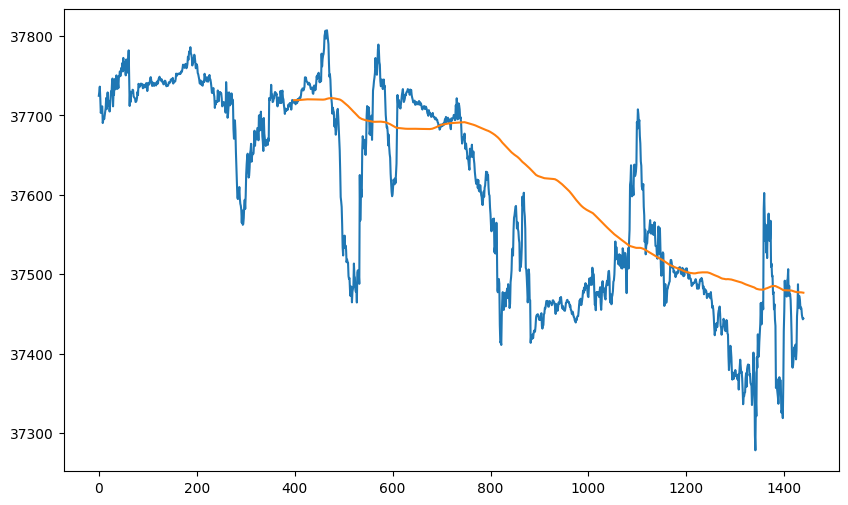

In [278]:
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import datetime
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from scipy.stats import linregress 

if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()


# SP500, US30 
# ETH BTC
# SP500, EURUSD
periods = 5 * 12 * 24 * 1
sp = pd.DataFrame(mt5.copy_rates_from_pos( "SP500", mt5.TIMEFRAME_M5, 0, periods ) )
nas = pd.DataFrame(mt5.copy_rates_from_pos( "US30", mt5.TIMEFRAME_M5, 0, periods ) )


seven_hours = datetime.timedelta(hours = 7)
sp = (
    sp.assign(time = pd.to_datetime( sp.time, unit="s") - seven_hours)
    .sort_index(ascending=True)
)
nas = (
    nas.assign(time = pd.to_datetime( nas.time, unit="s") - seven_hours)
    .sort_index(ascending=True)
)

pair_data = sp.join(nas, lsuffix="_sp", rsuffix="_nas", how="inner")

# adjust data so we can plot them on the same chart
pair_data = (
    pair_data
    .assign(sp_relative = pair_data.close_sp/pair_data.close_sp[0] *100 )
    .assign(nas_relative = pair_data.close_nas/pair_data.close_nas[0] *100 )

)
print("periods", periods)

plt.figure(figsize=(10,6))
#plt.plot(pair_data.index, pair_data.close_nas/pair_data.close_sp)
pair_data["ratio"] = pair_data.close_nas/pair_data.close_sp
pair_data["spread"] = pair_data.close_nas 

pair_data["ratio_ma"] = pair_data.ratio.rolling(400).mean()
pair_data["spread_ma"] = pair_data.spread.rolling(400).mean()


#print(pair_data.head()[["close_nas", "close_sp", "ratio", "spread"]])
#plt.plot(pair_data.index, pair_data.ratio)
#plt.plot(pair_data.index, pair_data.ratio_ma)

plt.plot(pair_data.index, pair_data.spread)
plt.plot(pair_data.index, pair_data.spread_ma)




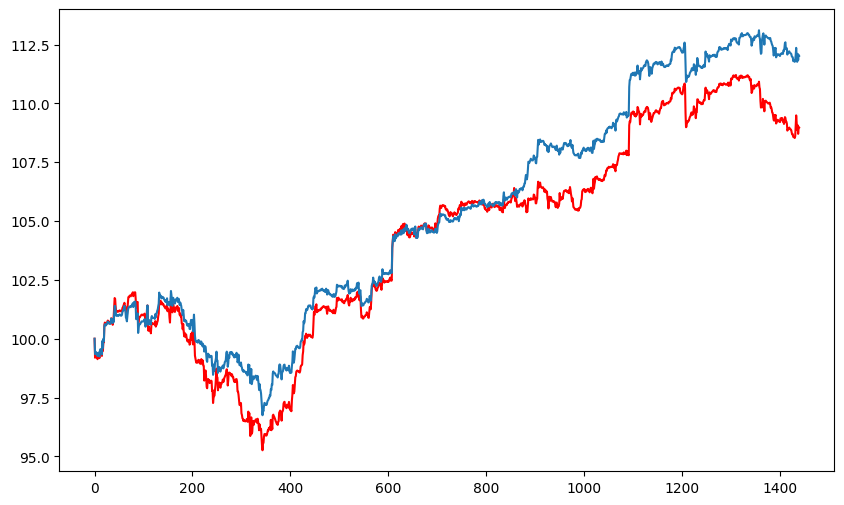

In [271]:

# sell DOW buy SP500

plt.figure(figsize=(10,6))
plt.plot( pair_data.index, pair_data.sp_relative, color="r")

plt.plot( pair_data.index, pair_data.nas_relative)

periods 1440


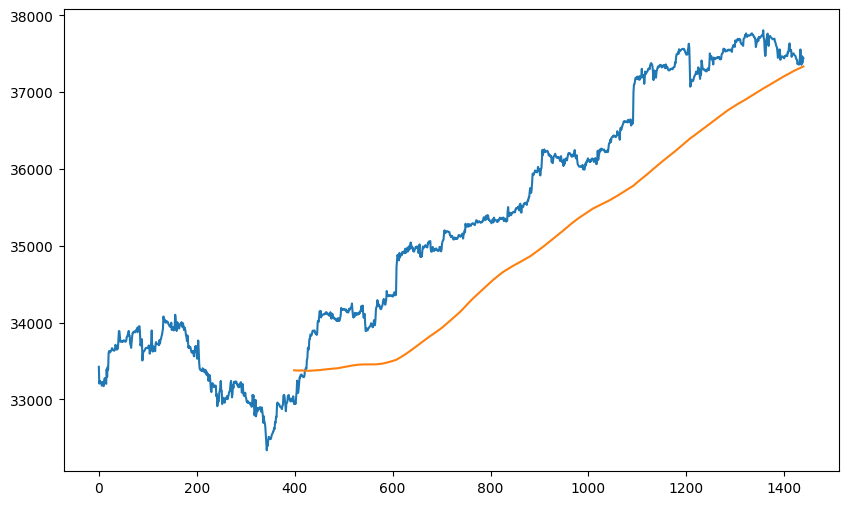

In [273]:
print("periods", periods)

plt.figure(figsize=(10,6))
#plt.plot(pair_data.index, pair_data.close_nas/pair_data.close_sp)
pair_data["ratio"] = pair_data.close_nas/pair_data.close_sp
pair_data["spread"] = pair_data.close_nas 

pair_data["ratio_ma"] = pair_data.ratio.rolling(400).mean()
pair_data["spread_ma"] = pair_data.spread.rolling(400).mean()


#print(pair_data.head()[["close_nas", "close_sp", "ratio", "spread"]])
#plt.plot(pair_data.index, pair_data.ratio)
#plt.plot(pair_data.index, pair_data.ratio_ma)

plt.plot(pair_data.index, pair_data.spread)
plt.plot(pair_data.index, pair_data.spread_ma)



<Axes: >

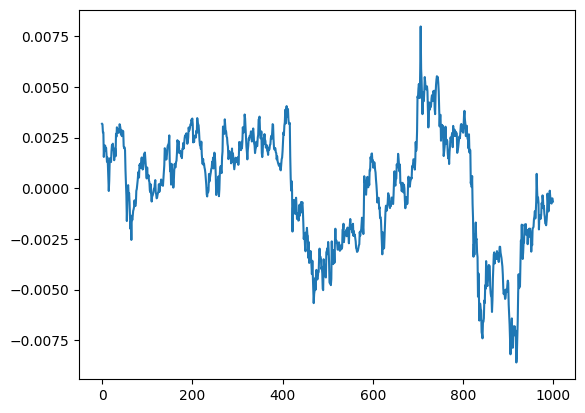

In [147]:
# cointegration test

# estimate linear regression and get spread
Y = np.log(pair_data.close_nas)
X = np.log(pair_data.close_sp)
X = sm.add_constant(X)

model = sm.OLS(Y, X)

results = model.fit()
results.params

alpha = results.params.values[0]
beta = results.params.values[1]

errors = Y - (alpha + X["close_sp"]* beta)

errors.plot()

In [148]:
# part 2
# dickey fuller test

dftest = adfuller(errors, maxlag=1)

dfoutput = pd.Series(
    dftest[0:4],
    index = ["Test Statistic", "p-value", "# Lags used", "# of Observations"]
)

critical_values = pd.Series(
    dftest[4].values(),
    index = dftest[4].keys()
)
# since we see that the test statisctic -2.9 is between 1% and 5% we can proceed
print(f"dicket fuller result\n{dfoutput}\n\n Critical Result\n {critical_values}")

dicket fuller result
Test Statistic        -2.813429
p-value                0.056381
# Lags used            0.000000
# of Observations    999.000000
dtype: float64

 Critical Result
 1%    -3.436913
5%    -2.864437
10%   -2.568313
dtype: float64


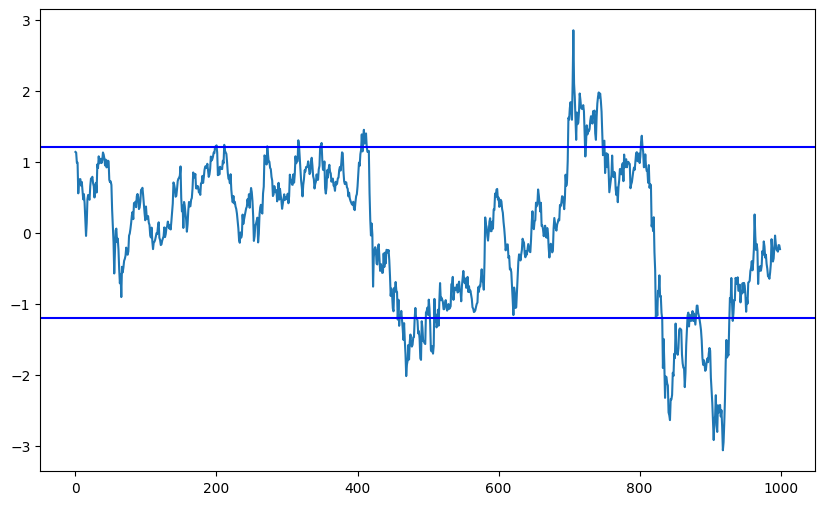

In [149]:
# z-score

spread = errors
zscore = (spread - np.mean(spread)) / np.std(spread)

plt.figure(figsize=(10,6))
zscore.plot(label="zscore")
plt.axhline(y=1.2, color="b", label="1.2 thresh")
plt.axhline(y=-1.2, color="b", label="-1.2 thresh")


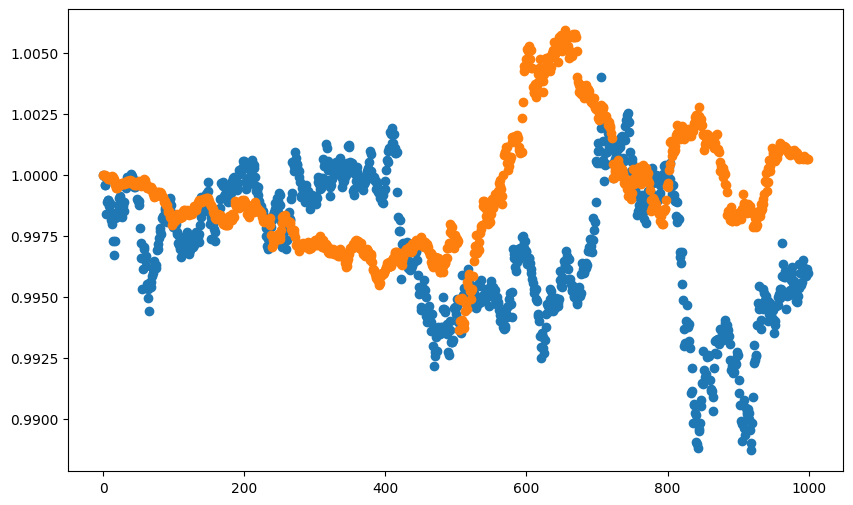

In [150]:
# Linear regressions version 2

plt.figure(figsize=(10,6))
plt.scatter(pair_data.index, pair_data.close_nas/pair_data.close_nas[0])
plt.scatter(pair_data.index, pair_data.close_sp/pair_data.close_sp[0])

In [151]:


result = linregress(pair_data.close_sp.values,pair_data.close_nas.values)

residuals = pair_data.close_sp - result.slope * pair_data.close_nas


dftest = adfuller(residuals)

In [152]:
print(dftest)


(-1.8480640790100724, 0.3568735587417944, 1, 998, {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573}, 3104.9068345140627)
